<a href="https://colab.research.google.com/github/Srivardini/TARA/blob/main/notebooks/TARA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **T**ime series **A**nalysis and **R**eduction **A**lgorithm

In [ ]:
!pip install photutils --quiet
!pip install astroalign --quiet
!pip install aafitrans --quiet

# **Imports**

In [6]:
import os
import pandas as pd
import csv

import numpy as np
import tqdm

import glob

import photutils as phot
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry
from astropy.stats import sigma_clipped_stats
from photutils.background import Background2D, MedianBackground, MeanBackground
from photutils.datasets import make_random_gaussians_table, make_gaussian_sources_image
from photutils.psf import EPSFBuilder, GriddedPSFModel
from photutils.psf import SourceGrouper, extract_stars, IterativePSFPhotometry, DAOPhotPSFPhotometry

from astropy.wcs import WCS
import astropy.stats as stats
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from astropy.convolution import Gaussian2DKernel, convolve_fft
from astropy.modeling import models, fitting
import astropy.units as u
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astropy.nddata import CCDData
from astropy.io import fits
from astropy.visualization import SqrtStretch
from astropy.visualization import simple_norm
from astropy.stats import SigmaClip, sigma_clipped_stats
from astropy.nddata import NDData

import matplotlib.pyplot as plt
import matplotlib.colors as col
from matplotlib.ticker import (MultipleLocator,AutoLocator, AutoMinorLocator)
# To improve Aesthetics of plots
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)
matplotlib.rcParams['font.size'] = 15
import matplotlib.animation as animation

import aafitrans as aaf
import astroalign as aa

from PIL import Image

import seaborn as sb

sb.set_style('white')

# **Core**

In [7]:
class Base():

  def detect_stars(self,data, th = 10):

    fwhm = self.fwhm
    sigma_clip = stats.SigmaClip(sigma=self.sigma)
    bkg_estimator = MedianBackground()

    bkg = Background2D( data,
                        self.box_size,
                        filter_size=self.filter_size,
                        sigma_clip=sigma_clip,
                        bkg_estimator=bkg_estimator)  #Background2D to detect the background of the image

    bkg_sub = data - bkg.background
    threshold = th*bkg.background_rms_median

    sigma = fwhm*stats.gaussian_fwhm_to_sigma  # FWHM = 20
    kernel = Gaussian2DKernel(x_stddev=sigma)

    convolved_data = convolve_fft(bkg_sub, kernel)

    daofind = DAOStarFinder(threshold, fwhm)

    sources = daofind(convolved_data)

    return sources, bkg, convolved_data

  def perform_photometry(self,sources, data, gain =1, RN=3, DC=2,
                         r = 3, r_in = 10, r_out = 15):

    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=r)
    bags = CircularAnnulus(positions, r_in, r_out)

    ap_pix = apertures.area                                                                                             # calculating the aperture area
    bag_pix = bags.area                                                                                                 # calculating the annulus area

    phot_table = aperture_photometry(data, [apertures,bags])                                                            # calling the package Photutils_aperture_photometry

    phot_table['sky_flux'] = phot_table['aperture_sum_1'].value*(ap_pix/bag_pix)                                              # calculating sky flux by drawing an annulus

    phot_table['flux'] = phot_table['aperture_sum_0'].value - \
                        phot_table['sky_flux'].value                              # calculating source flux

    Noise_2 = gain*(phot_table['flux'].value  + phot_table['sky_flux'].value)+\
                     (DC + RN**2 + (gain/2)**2)*ap_pix

    phot_table['flux_err'] = np.sqrt(Noise_2)          # calculating error on the source flux

    phot_table['SNR'] = phot_table['flux']/phot_table['flux_err']                                                       # calculating signal to noise ratio

    return phot_table, (apertures,bags)
  
def update_dirs(out_dir):
    if not os.path.exists(f'{out_dir}/images'):
      os.mkdir(f'{out_dir}/images')

    else:
      os.system(f"rm {out_dir}/images/*")

    if not os.path.exists(f'{out_dir}/exposure_images'):
      os.mkdir(f'{out_dir}/exposure_images')

    else:
      os.system(f"rm {out_dir}exposure_images/*")

    if not os.path.exists(f'{out_dir}/animations'):
      os.mkdir(f'{out_dir}/animations')

    else:
      os.system(f"rm {out_dir}animations/*")

    if not os.path.exists(f'{out_dir}/SNR_table'):
      os.mkdir(f'{out_dir}/SNR_table')
    else:
      os.system(f"rm {out_dir}/SNR_table/*")

    if not os.path.exists(f'{out_dir}/cube'):
      os.mkdir(f'{out_dir}/cube')
    else:
      os.system(f"rm {out_dir}/cube/*")

    if not os.path.exists(f'{out_dir}/coordinates'):
      os.mkdir(f'{out_dir}/coordinates')
    else:
      os.system(f"rm {out_dir}/coordinates/*")


# **TARA**

In [19]:
class tara(Base):

  def __init__(self, input_files=[], out_dir='.', box_size=64,
               sigma=3,fwhm=10, gain=68, filter_size=(3,3), crop_image=False,
               x_cen=None, y_cen = None,
               size=0, bin_image=False, bin_fact=1):

    self.box_size = box_size
    self.fwhm = fwhm
    self.gain = gain
    self.sigma = sigma
    self.filter_size = filter_size
    self.crop_image = crop_image
    self.bin_image = bin_image
    self.bin_fact = bin_fact
    self.time = []

    self.align_phot = False
    self.align_sources = []

    exps = [i for i in input_files if 'fits' in i.split('.')[-1]]

    if len(exps)<1:
      raise Exception("No '.fits' files in input list")

    self.exps = exps
    hdul = fits.open(exps[0])
    for ext in range(len(hdul)):
      img = hdul[ext].data
      if img is not None: 
        break
    self.ext = ext
    self.shape = img.shape
    print("-------------------------------------------------")
    print(f"Input directory contains {len(exps)} '.fits' 'files")

    if crop_image:
        if x_cen is not None and y_cen is not None and size>0:
          img = img[x_cen - size: x_cen + size,
                    y_cen - size: y_cen + size].copy()
          print('Input image is Cropped')
          self.x_cen = x_cen
          self.y_cen = y_cen
          self.size = size
          self.shape = img.shape
        else:
          self.crop_image = False

    if bin_image:
      if img.shape[0] % bin_fact == 0 and img.shape[1] % bin_fact ==0 :
        x_bin = img.shape[0]//bin_fact
        y_bin = img.shape[0]//bin_fact

        img = img.reshape(x_bin, bin_fact,y_bin, bin_fact).sum(axis=(1,3))
        print("Input image is binned")

        self.x_bin = x_bin
        self.y_bin = y_bin
        self.bin_fact = bin_fact

      else:
        self.bin_image = False

    print(f"Image shape: {self.shape}")
    print("-------------------------------------------------")

    self.out_dir=out_dir

  def show_image(self, cmap='jet', norm='sqrt', fig=None, id=0,
                 check_photometry=True, th=1, r=10, r_in=None, r_out=None):

    hdul = fits.open(self.exps[id])
    img = hdul[self.ext].data

    if fig is None:
      fig = plt.figure(figsize=(7,7))
      ax = fig.add_subplot()

    norm = simple_norm(img, norm, percent=99.)
    ax.imshow(img, cmap=cmap, norm=norm)

    if check_photometry:
      if r_in is None or r_out is None:
        r_in = r*1.2                             #Changed r_in/out from r*1.2/.5
        r_out = r*1.5

      sources, _, _ = self.detect_stars(img ,th=th)

      phot_table, apers = self.perform_photometry(sources, img,
                                                  gain=self.gain,
                                                  r=r, r_in=r_in, 
                                                  r_out=r_out)

      apers[0].plot(ax, color='blue')
      apers[1].plot(ax, color='black')

    return fig, ax, phot_table

  def gen_cube(self, th=10, start=0, end=-1, r=1, r_in = None, r_out = None,
               mar_pix=5, plot=False, ref_pos=None, mask_hot_pixel=False):


    if r_in is None:
      r_in = r*1.2
    if r_out is None:
      r_out = r*1.5

    poss = []
    imgs = []

    path = f'{self.out_dir}/images'

    if len(os.listdir(path))>0:
      os.system(f"rm {self.out_dir}/images/*")

    aa_flag = True
    for i,exp in enumerate(tqdm.tqdm(self.exps[int(start):int(end)], colour = 'GREEN')):

      hdul = fits.open(exp)
      img = hdul[self.ext].data

      time = i#hdul[self.ext].header['JD_UTC']
      hdul.close()

      if self.crop_image:
          img = img[self.x_cen - self.size:self.x_cen + self.size,
                    self.y_cen - self.size:self.y_cen + self.size].copy()

      if img.shape != self.shape:
        print(f"\nImage shape is {img.shape} not {self.shape}. Skipping")
        continue

      if mask_hot_pixel:
        mask = np.where(img>0.5*(2**16),0,1)
      else:
        mask = 1

      img = mask*img

      if self.bin_image:
        img = img.reshape(self.x_bin, self.bin_fact,
                          self.y_bin, self.bin_fact).sum(axis = (1,3))


      try:
        sources, bkg, conv_data = self.detect_stars(img,th=th)

      except:
        print(f'Background detection failed for {exp}')
        continue

      if sources is None:
        print(f"No sources detected using DAOfind for {exp}")
        continue

      y_len, x_len = img.shape

      # Removing sources on top and bottom as those regions have high noise

      sources = sources[(sources['ycentroid']<y_len-mar_pix) &
                        (sources['ycentroid']>mar_pix)]

      sources = sources[(sources['xcentroid']<x_len-mar_pix) &
                        (sources['xcentroid']>mar_pix)]

      #Performing aperture photometry
      phot_table, apers = self.perform_photometry(sources, img, self.gain,
                                                  r=r, r_in=r_in, r_out=r_out)

      phot_table.sort('SNR', reverse=True)

      # reducing the sources to just 20 sources to speed the process

      phot_table = phot_table[:20]

      pos = np.transpose([phot_table['xcenter'],phot_table['ycenter']])

      poss.append(pos)

      if ref_pos is not None and aa_flag:

        if len(ref_pos)>5:
          print('\nUsing user reference catalog\n')
          aa_flag= False
          target_ref = ref_pos
          ref_img = img

      if aa_flag:

        source_sel = phot_table[phot_table['SNR']>1]

        if len(source_sel)>2:
          aa_flag = False
          target_ref = np.transpose([source_sel['xcenter'],source_sel['ycenter']])
          ref_img = img.copy()
          imgs.append(img)

        else:
          print("Astroalign requires atleast 3 sources in field")

      elif len(phot_table)>2:

        try:
          transf, (source_list, target_list) = aaf.find_transform(pos,target_ref,
                                                                  min_matches=3)

          registered_image = aa.apply_transform(transf, img, ref_img)
          self.time.append(time)

          if self.align_phot:
            sources_, _, _ = self.detect_stars(registered_image[0],
                                                        th=th)
            pos_ = np.transpose([sources_['xcentroid']
                                  ,sources_['ycentroid']])

            self.align_sources.append(pos_)

          img= registered_image[0]

          imgs.append(img)

        except:

          print(f"\nAA failed for {exp}")
      else:
        print("Target image has <3 sources")

      if plot:
        norm = simple_norm(img,'sqrt', percent=99.)
        fig, ax = plt.subplots(figsize=(5,5))
        im = ax.imshow(img, norm=norm, cmap='jet')
        ax.axis(False)
        apers[0].plot(ax, color='blue')
        apers[1].plot(ax, color='black')

        ax.set_title('Image exposure')
        ax.annotate(f'{i}', (10,20), color = 'black',fontsize=10)
        fig.savefig(f'{self.out_dir}/images/{i}.png')
        plt.close(fig)


    poss = np.array(poss, dtype=object)  #making it an array to save as fits file

    return np.array(imgs), poss

  def __call__(self, th=1, rnge=[0,-1], step=1,
                r=1, r_in = None, r_out = None,
                th_cube=None, ref_pos=None, ref_img=None,
              mar_pix=5, mask_hot_pixel=False):
    
    update_dirs(self.out_dir)

    if r_in is None or r_out is None:
      r_in = r*1.2
      r_out = r*1.5

    for i in range(rnge[0], rnge[1]):
      print("------------------------------------")
      print("Iteration:", i)
      start = i*step
      end = (i+1)*step

      if i==1 and ref_pos is None:
        ref_pos = poss[0]

      cube, poss = self.gen_cube( th=th,
                                  start=start, end=end,
                                  r=r, r_in=r_in, r_out=r_out,
                                  mar_pix=mar_pix,
                                  ref_pos=ref_pos,
                                  mask_hot_pixel=mask_hot_pixel)

      fits.writeto(f'{self.out_dir}/cube/{i*step}_{(i+1)*step}cube.fits',
                    cube, overwrite=True)

      np.save(f'{self.out_dir}/coordinates/{i*step}_{(i+1)*step}x_y.npy',
                    poss)

      if i==0 and ref_img is None:
        ref_img = np.median(cube, axis=0)

      if th_cube is None:
        th_cube = 5*th

      sources, _, _ = self.detect_stars(ref_img ,th=th_cube)

      phot_table, _ = self.perform_photometry(sources, ref_img,
                                                gain=self.gain,
                                                r=r, r_in=r_in, r_out=r_out)

      flux = []
      sky_flux = []
      flux_err = []
      SNR = []

      for img in cube:

        phot_table, _ = self.perform_photometry(sources, img, gain=self.gain,
                                                  r=r, r_in=r_in, r_out=r_out)
        flux.append(phot_table['flux'].value)
        flux_err.append(phot_table['flux_err'].value)
        sky_flux.append(phot_table['sky_flux'].value)
        SNR.append(phot_table['SNR'].value)

      phot_table['flux'] =  np.array(flux).T
      phot_table['flux_err'] = np.array(flux_err).T
      phot_table['sky_flux'] = np.array(sky_flux).T
      phot_table['SNR'] = np.array(SNR).T


      out_file = f'{self.out_dir}/SNR_table/{i*step}_{(i+1)*step}Phot_table.fits'
      phot_table.write(out_file, overwrite=True)

    self.cube = cube
    self.poss = poss
    self.phot_table = phot_table
    return ref_pos, ref_img

  def merge_phot_table(self, out_dir='.'):

    tab_name = glob.glob(f'{self.out_dir}/SNR_table/*')
    tab_name = sorted(tab_name, key=lambda x: int(x.split('/')[-1].split('_')[0]))

    # Concatenate photometry of all cubes

    for i, f in enumerate(tqdm.tqdm(tab_name, colour = 'GREEN')):
      phot_table = Table.read(f)
      print(phot_table)
      phot_table['SNR_mean'] = phot_table['SNR'].mean(axis=1)
      phot_table.sort('SNR_mean', reverse=True)
      if i == 0 :
        flux = phot_table['flux'].value
        sky_flux = phot_table['sky_flux'].value
        flux_err = phot_table['flux_err'].value
        SNR = phot_table['SNR'].value

      else:
        flux = np.concatenate([flux, phot_table['flux'].value], axis = 1 )
        flux_err = np.concatenate([flux_err, phot_table['flux_err'].value], axis = 1 )
        sky_flux = np.concatenate([sky_flux, phot_table['sky_flux'].value], axis = 1 )
        SNR = np.concatenate([SNR, phot_table['SNR'].value], axis = 1 )


    phot_table['flux'] =  np.array(flux)
    phot_table['flux_err'] = np.array(flux_err)
    phot_table['sky_flux'] = np.array(sky_flux)
    phot_table['SNR'] = np.array(SNR)

    self.phot_table = phot_table
    return phot_table

# **Utils**

In [9]:
def gen_plot(data, key='SNR', t=None, out_dir='.',hdul = None, fmt='o',
             camera_name = None,id = None, fig=None, ax =None, figsize=(15,5),
             bin_fact = 1, diff_phot=False, norm=False, lw=2, slice_end=-1):

    if fig is None or ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
    if t is None:
        t = np.arange(0,len(data[key][0]), 1)[:slice_end]

    if len(data[key][0][0:slice_end])%bin_fact ==0:
      t = t.reshape(-1, bin_fact).mean(axis=1)
      flag = True
      ref = 0
      for row in data:
          x = np.array(row[key])[:slice_end]
          x = x.reshape(-1, bin_fact).mean(axis=1)

          if diff_phot:
            if flag:
              source = x
              flag = False
            else:
              ref += x
          else:
            if norm:
              x = x/x.mean()
            ax.plot(t,x, alpha=1,s=20, fmt=fmt)
    else:
       raise Exception("Binning Failed. Try changing bin_fact")
    if diff_phot:
      source = source/source.mean()
      ref =  ref/ref.mean()
      ax.plot(t,source/ref, 'o', alpha=1)

      # Assuming standard deviation as error for demonstration
      y_err = np.std(source/ref)
      ax.errorbar(t, source/ref, yerr=y_err, fmt='o', alpha=1)

    #ax.set_xlabel('Frames')
    ax.set_ylabel(f'{key}')

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
                bottom = True, left = True)
    ax.tick_params(which='major', length=7,direction="in")
    ax.tick_params(which='minor', length=4, color='black',direction="in")
    #ax.set_title(f'{key} vs Frames - {id}')
    if hdul is not None:
        text = f"""Obervation Date : {hdul[0].header['DATE-OBS']} \nCamera name     : {camera_name}
        Exposure Time    : {hdul[0].header['EXPTIME']}"""      #\nGain                    : {hdul[0].header['GAIN']}

        ax.text(-3,1.02*np.max(x), text, fontsize=15,
                bbox=dict(facecolor='red', alpha=0.2))
    fig.savefig(f'{out_dir}/exposure_images/{id}.png')
    return fig, ax

In [10]:
def gen_anim(id, out_dir='.'):

  imgs = glob.glob(f'{out_dir}/images/*')
  ims = []
  for img in imgs:
    image = plt.imread(img)
    ims.append(image)

  def update(i,im,ims):
      im.set_array(ims[i])
      return im,

  # Create the figure and axes objects
  l = glob.glob(f"{out_dir}/images/*")
  l.sort()
  frames = [Image.open(image) for image in l]
  frame_one = frames[0]
  frame_one.save(f"{out_dir}/animations/{id}.gif", format="GIF", append_images=frames,
                save_all=True, duration=len(frames)/2, loop=0)
  return frames, frame_one

# **Testing**

In [14]:
data_dir = '../src/tara/data/'
exps = glob.glob(f'{data_dir}/pista_sim/*.fits')
exps = sorted(exps, key=lambda x: int(x.split('\\')[-1].split('_')[0]))

In [22]:
tar_obj = tara(exps,'.')

-------------------------------------------------
Input directory contains 101 '.fits' 'files
Image shape: (300, 300)
-------------------------------------------------


ValueError: too many values to unpack (expected 2)

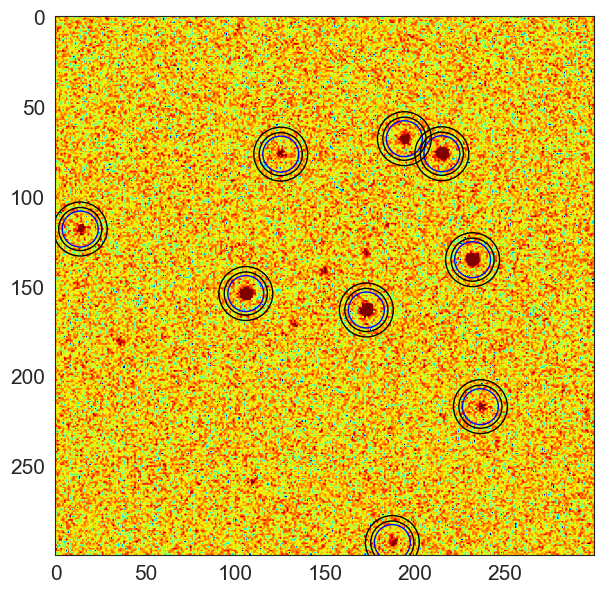

In [23]:
fig, ax = tar_obj.show_image()

In [26]:
import platform

'Windows'

In [24]:
rnge = [0,10]
step = 10

ref_pos, ref_img = tar_obj(th=1, rnge=rnge, step=step)

------------------------------------
Iteration: 0


100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


------------------------------------
Iteration: 1


  0%|          | 0/10 [00:00<?, ?it/s]


Using user reference catalog



100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


------------------------------------
Iteration: 2


  0%|          | 0/10 [00:00<?, ?it/s]


Using user reference catalog



100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


------------------------------------
Iteration: 3


  0%|          | 0/10 [00:00<?, ?it/s]


Using user reference catalog



100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


------------------------------------
Iteration: 4


  0%|          | 0/10 [00:00<?, ?it/s]


Using user reference catalog



100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


------------------------------------
Iteration: 5


  0%|          | 0/10 [00:00<?, ?it/s]


Using user reference catalog



100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


------------------------------------
Iteration: 6


  0%|          | 0/10 [00:00<?, ?it/s]


Using user reference catalog



100%|██████████| 10/10 [00:02<00:00,  4.36it/s]


------------------------------------
Iteration: 7


  0%|          | 0/10 [00:00<?, ?it/s]


Using user reference catalog



100%|██████████| 10/10 [00:02<00:00,  4.13it/s]


------------------------------------
Iteration: 8


  0%|          | 0/10 [00:00<?, ?it/s]


Using user reference catalog



100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


------------------------------------
Iteration: 9


  0%|          | 0/10 [00:00<?, ?it/s]


Using user reference catalog



100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


In [ ]:
rnge = [10,20]
step = 10

ref_pos, ref_img = tar_obj(th=1, rnge=rnge, step=step,
                           ref_pos=ref_pos,
                           ref_img=ref_img)

------------------------------------
Iteration: 2


  0%|          | 0/2 [00:00<?, ?it/s]


Using user reference catalog



100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


------------------------------------
Iteration: 3


  0%|          | 0/2 [00:00<?, ?it/s]


Using user reference catalog



100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


In [ ]:
phot_table = tar_obj.merge_phot_table('/content/')

100%|██████████| 4/4 [00:00<00:00, 71.48it/s]


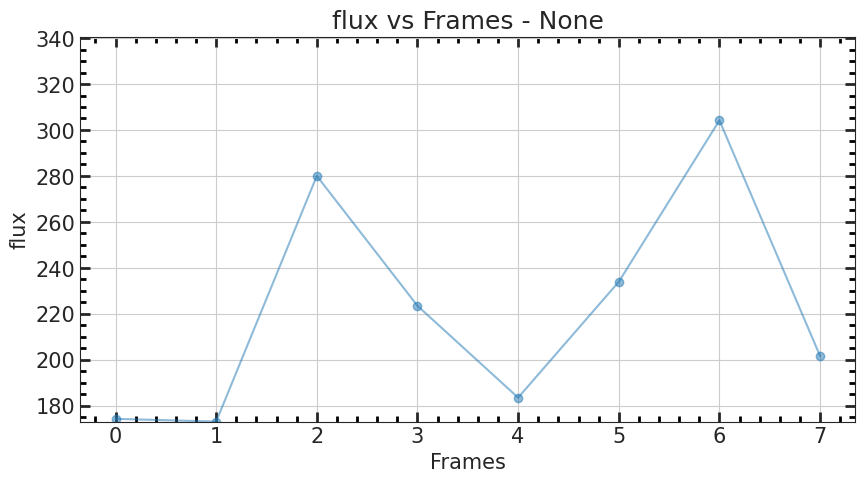

In [ ]:
fig, ax = gen_plot(phot_table[0:1], 'flux', '/content/')

In [ ]:
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,sky_flux,flux,flux_err,SNR,SNR_mean
,pix,pix,,,,,,,
int64,float64,float64,float64,float64,float64[8],float64[8],float64[8],float64[8],float64
4,285.8000949632485,431.1791245601377,7130.134227582226,5612.096366152166,6643.703270522618 .. 6928.514032286625,174.22457343315182 .. 201.62019529560166,102.22332880270321 .. 103.73916972451643,1.7043523770333784 .. 1.9435300651722225,2.4206114528981733
3,225.43341587413462,412.0716312069215,6830.502587569266,5401.271255778286,6727.634814908481 .. 6668.236118244798,160.78376424832732 .. 162.26646932446874,102.56753719723707 .. 102.28481654243247,1.5675892065063493 .. 1.586417953412989,1.6808741016519884
2,267.93717267539836,260.9635902285545,7092.497626647341,5719.451863524043,6637.06003374349 .. 7061.051683363015,199.19505256855973 .. 31.44594328432595,102.31293268136658 .. 103.55761070146966,1.9469195862942703 .. 0.30365651612971867,1.3493117128264933
5,394.6854016804878,494.96408837548756,6604.868410358313,5272.492541538401,7247.140848396364 .. 6509.250051281977,166.0632383605507 .. 95.61835907633576,105.09464874248697 .. 101.1758346538743,1.580130295382164 .. 0.9450711170651487,0.9951053785576002
1,191.26909447020597,31.456574469546048,6448.6568709848425,5185.567953727036,6426.664961209051 .. 6401.93574534202,75.16500171699317 .. 46.7211256428227,100.66534195280839 .. 100.40088634337171,0.746682028381032 .. 0.4653457488715402,0.476848811253905
